In [130]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandasql import sqldf 

### Read and Explore the Datasets

In [131]:
data_orders = pd.read_csv('datasets/data_orders.csv')

In [132]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [133]:
data_orders.shape

(10716, 8)

In [134]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [135]:
data_offers = pd.read_csv('datasets/data_offers.csv')

In [136]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


We would like to merge the two DataFrames into one for easier manipulation. We would be using SQL Inner JOIN function to achieve that. Then, we print a sample of the merged DataFrame.

In [164]:
pysqldf = lambda q: sqldf(q, globals())

In [165]:
query = '''
        SELECT order_datetime, origin_longitude, origin_latitude, m_order_eta, data_orders.order_gk, order_status_key, is_driver_assigned_key, cancellations_time_in_seconds, offer_id
        FROM data_orders 
        INNER JOIN 
        data_offers 
        ON data_orders.order_gk = data_offers.order_gk
        '''
df = pysqldf(query)

In [166]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976271


There may be something we can do to slightly raise the data quality. In the case of order status key and is driver assigned key, for instance, the values are merely keys that refer to an internal description and are not indicative of the contents. In place of their current values, we could substitute more informative text, such as replacing the 1s in is driver assigned key with the string Yes and the 0s with the string No.

In [140]:
df.loc[df['order_status_key'] == 4, 'order_status_key'] = 'Client Cancelled'
df.loc[df['order_status_key'] == 9, 'order_status_key'] = 'System Cancelled'
df.loc[df['is_driver_assigned_key'] == 1, 'is_driver_assigned_key'] = 'Yes'
df.loc[df['is_driver_assigned_key'] == 0, 'is_driver_assigned_key'] = 'No'

In [167]:
df = df.rename(columns={
    "order_datetime": "order_time"
})

In [168]:
df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976271


### Build up a distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

One, straightforward solution to solve this question is to use the groupby method in SQL by the is_driver_assigned and order_status columns, and then count the rows in each group, i.e., each combination of values for the grouping columns.

Since both are binary variables (have only two possible values), there are four possible combinations. 

A significant amount of requests are cancelled before a driver is assigned, which suggests that perhaps customers have chosen an alternative for their transportation needs because they waited too long. 9469 orders have been rejected by the system, and 13435 orders have been canceled by clients. Only four of the 8360 customer cancellations that occurred after a driver was assigned were for some reason rejected by the system.

Another approach to solve this question is by Pivot tables. 

Solving using SQL

In [143]:
query = '''
        SELECT order_status_key, is_driver_assigned_key, COUNT(order_gk)
        FROM df
        GROUP BY order_status_key, is_driver_assigned_key
        '''
df1 = pysqldf(query)
df1

,order_status_key,is_driver_assigned_key,COUNT(order_gk)
0,Client Cancelled,No,13435
1,Client Cancelled,Yes,8360
2,System Cancelled,No,9469
3,System Cancelled,Yes,4


Solving using Pivot Table

In [144]:
table = df.pivot_table(columns=['is_driver_assigned_key','order_status_key'],values=['order_gk'], aggfunc="count")
table

is_driver_assigned_key               No                               Yes  \
order_status_key       Client Cancelled System Cancelled Client Cancelled   
order_gk                          13435             9469             8360   

is_driver_assigned_key                   
order_status_key       System Cancelled  
order_gk                              4

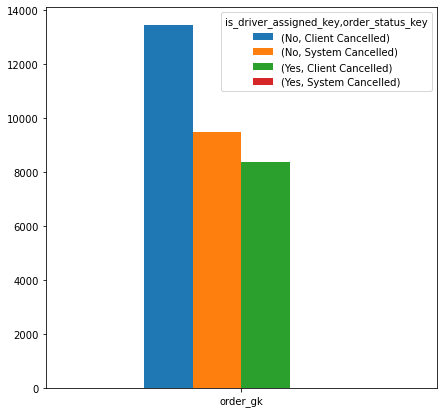

In [145]:
_ = table.plot(kind="bar", subplots=False, figsize=(7, 7), legend=True, rot=0)


### Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

This question expands on the preceding one by going more in-depth with the study of unsuccessful orders. We want to know when these fails occur and if there is a certain time of day when one category predominates over another, rather than merely plotting the distribution of fails by category (cause for cancellation, and the driver assignment).

In [146]:
df['time'] = pd.to_datetime(df.order_time)

# Creating new column with just the date
df['new_hour_col'] = df['time'].dt.hour

In [147]:
df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,time,new_hour_col
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,Client Cancelled,Yes,198.0,300050983403,2022-10-20 18:08:07,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,No,128.0,300050986174,2022-10-20 20:57:32,20
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,No,128.0,300050986179,2022-10-20 20:57:32,20
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,No,128.0,300050986180,2022-10-20 20:57:32,20
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,Client Cancelled,Yes,46.0,300050976271,2022-10-20 12:07:50,12


Solving using SQL

In [148]:
query = '''
        SELECT new_hour_col, order_status_key, is_driver_assigned_key, COUNT(order_gk) AS orders_count
        FROM df
        GROUP BY new_hour_col
        '''
df2 = pysqldf(query)
df2

,new_hour_col,order_status_key,is_driver_assigned_key,orders_count
0,0,Client Cancelled,Yes,1993
1,1,Client Cancelled,Yes,1305
2,2,Client Cancelled,Yes,1475
3,3,Client Cancelled,No,1418
4,4,Client Cancelled,No,227
5,5,System Cancelled,No,111
6,6,Client Cancelled,No,392
7,7,System Cancelled,No,1566
8,8,System Cancelled,No,3865
9,9,Client Cancelled,No,1258


In [149]:
query = '''
        SELECT new_hour_col, order_status_key, is_driver_assigned_key, COUNT(order_gk) AS orders_count
        FROM df
        GROUP BY new_hour_col, is_driver_assigned_key, order_status_key
        '''
df2 = pysqldf(query)
df2

,new_hour_col,order_status_key,is_driver_assigned_key,orders_count
0,0,Client Cancelled,No,957
1,0,System Cancelled,No,706
2,0,Client Cancelled,Yes,326
3,0,System Cancelled,Yes,4
4,1,Client Cancelled,No,633
...,...,...,...,...
68,22,System Cancelled,No,660
69,22,Client Cancelled,Yes,415
70,23,Client Cancelled,No,1144
71,23,System Cancelled,No,883


Solving using Pivot Table

In [150]:
table = pd.pivot_table(df2,index=['new_hour_col', 'order_status_key','is_driver_assigned_key'],values=['orders_count'], aggfunc=np.sum)
table

orders_count
new_hour_col order_status_key is_driver_assigned_key              
0            Client Cancelled No                               957
                              Yes                              326
             System Cancelled No                               706
                              Yes                                4
1            Client Cancelled No                               633
...                                                            ...
22           Client Cancelled Yes                              415
             System Cancelled No                               660
23           Client Cancelled No                              1144
                              Yes                              444
             System Cancelled No                               883

[73 rows x 1 columns]

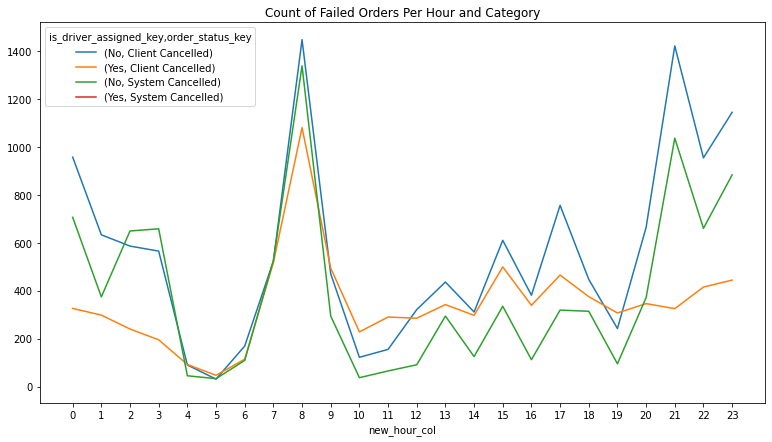

In [151]:
_ = table.reset_index().pivot(index="new_hour_col",
                                   columns=["is_driver_assigned_key", "order_status_key"],
                                   values="orders_count").plot(xticks=range(0, 24),
                                                           figsize=(13, 7),
                                                           title="Count of Failed Orders Per Hour and Category")


The four system rejects with the assigned driver occurred around midnight (see the output of the grouped DataFrame). The rest of the categories follow similar distribution, with the client cancellations with the assigned driver having a substantially lower count during the night hours.

### Plot the average time to cancellation with and without driver, by hour. Can we draw any conclusions from this plot?

We'll use the same strategy we used to answer the last question to find the answer to this one.

We'll first group the DataFrame according to the order hour and the driver-assignment flag. The cancellations time in seconds column will then be combined with the mean function. This will provide us with the necessary, compiled data.

In [152]:
df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,time,new_hour_col
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,Client Cancelled,Yes,198.0,300050983403,2022-10-20 18:08:07,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,No,128.0,300050986174,2022-10-20 20:57:32,20
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,No,128.0,300050986179,2022-10-20 20:57:32,20
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,No,128.0,300050986180,2022-10-20 20:57:32,20
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,Client Cancelled,Yes,46.0,300050976271,2022-10-20 12:07:50,12


In [153]:
query = '''
        SELECT new_hour_col, is_driver_assigned_key, AVG(cancellations_time_in_seconds) AS avg_time
        FROM df
        GROUP BY new_hour_col, is_driver_assigned_key 
        ORDER BY new_hour_col
        '''
df3 = pysqldf(query)
df3.head()

,new_hour_col,is_driver_assigned_key,avg_time
0,0,No,115.126437
1,0,Yes,276.082822
2,1,No,100.593997
3,1,Yes,296.312081
4,2,No,121.305461


In [154]:
table = pd.pivot_table(df,index=['new_hour_col','is_driver_assigned_key'],values=['cancellations_time_in_seconds'], aggfunc=np.mean)
table

cancellations_time_in_seconds
new_hour_col is_driver_assigned_key                               
0            No                                         115.126437
             Yes                                        276.082822
1            No                                         100.593997
             Yes                                        296.312081
2            No                                         121.305461
             Yes                                        301.466667
3            No                                         129.182301
             Yes                                        368.682051
4            No                                         100.733333
             Yes                                        245.250000
5            No                                         102.838710
             Yes                                        156.617021
6            No                                         202.952663
             Yes                                        225.508772
7            No                                         141.177820
             Yes                                        177.640232
8            No                                         132.625432
             Yes                                        172.896296
9            No                                         138.014894
             Yes                                        230.821862
10           No                                          93.795082
             Yes                                        206.447368
11           No                                          93.090323
             Yes                                        276.793103
12           No                                         128.224299
             Yes                                        243.000000
13           No                                         103.577982
             Yes                                        248.301170
14           No                                         112.752412
             Yes                                        241.367003
15           No                                         140.970492
             Yes                                        188.380762
16           No                                         123.181102
             Yes                                        217.126844
17           No                                         106.842593
             Yes                                        280.782796
18           No                                          85.845638
             Yes                                        270.277333
19           No                                         103.231405
             Yes                                        151.039088
20           No                                         117.518072
             Yes                                        214.517341
21           No                                         130.828290
             Yes                                        224.443077
22           No                                         103.662474
             Yes                                        230.720482
23           No                                         117.294580
             Yes                                        320.189189

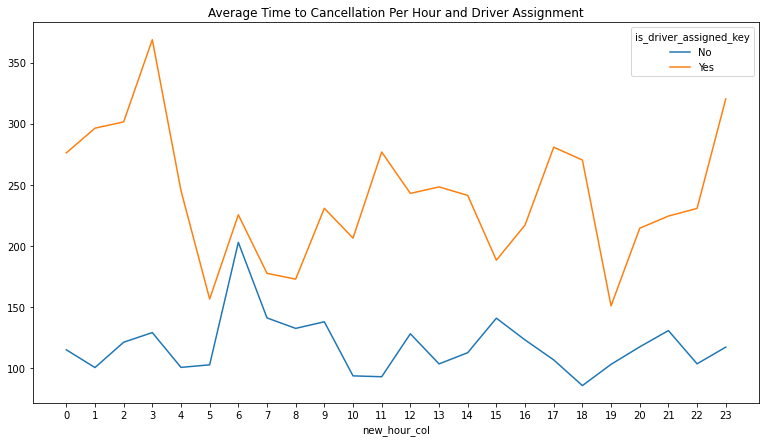

In [155]:
_ = table.reset_index().pivot(index="new_hour_col",
                                   columns=["is_driver_assigned_key"],
                                   values="cancellations_time_in_seconds").plot(xticks=range(0, 24),
                                                           figsize=(13, 7),
                                                           title="Average Time to Cancellation Per Hour and Driver Assignment")


The average time to cancellation is higher on orders with an assigned driver than without, for each hour without exception. The peak occurs at 3 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

### Plot the distribution of average ETA by hours. How can this plot be explained?

The solution to this question is quite straightforward. We simply group-by the DataFrame on the order hour, and aggregate the m_order_eta column with a mean function. Then, we plot the resulting DataFrame. The result is in the cell immediately below. The line very closely matches the count of failed orders per hour, indicating that the number of failed orders increases as the average waiting time of the client increases.

In [156]:
table = pd.pivot_table(df,index=['new_hour_col'],values=['m_order_eta'], aggfunc=np.mean)
table

,m_order_eta
new_hour_col,
0,375.433333
1,355.322148
2,389.554167
3,381.492308
4,266.119565
5,476.787234
6,489.456140
7,642.746615
8,671.086111


<AxesSubplot:title={'center':'Average ETA per hour'}, xlabel='new_hour_col'>

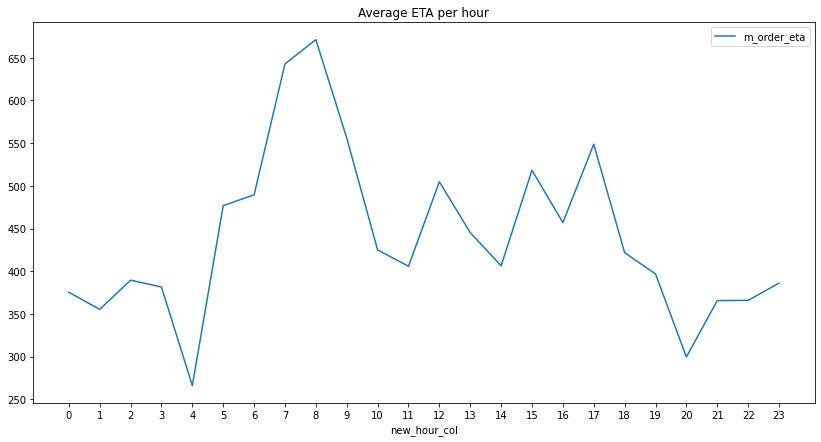

In [157]:
table.plot(figsize=(14, 7),
                xticks=range(0, 24),
                title="Average ETA per hour")

### Using the h3 and folium packages, calculate how many size 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [158]:
import h3

hex_ids = df.apply(lambda row: h3.geo_to_h3(row.origin_latitude, row.origin_longitude, resolution = 8), axis = 1)
df = df.assign(hex_id=hex_ids.values)

In [159]:
dfbyhexid = df.groupby("hex_id", as_index=False).agg({"order_gk": "count"})

In [160]:
dfbyhexid

,hex_id,order_gk
0,88195d2801fffff,65
1,88195d2803fffff,14
2,88195d2805fffff,10
3,88195d2807fffff,3
4,88195d2809fffff,46
...,...,...
134,88195d749dfffff,2
135,88195d74d1fffff,1
136,88195d74d3fffff,4
137,88195d74d5fffff,1


In [161]:
dfbyhexid = dfbyhexid.sort_values(by="order_gk")  # 1
total_orders = dfbyhexid["order_gk"].sum()  # 2
dfbyhexid["cum_sum"] = dfbyhexid["order_gk"].cumsum()  # 3
dfbyhexid["cum_perc"] = 100 * dfbyhexid["cum_sum"] / total_orders  # 4
dfbyhexid[dfbyhexid["cum_perc"] <= 80]  # 5

,hex_id,order_gk,cum_sum,cum_perc
137,88195d74d5fffff,1,1,0.003198
135,88195d74d1fffff,1,2,0.006396
79,88195d2aebfffff,1,3,0.009594
11,88195d282bfffff,1,4,0.012793
122,88195d3993fffff,1,5,0.015991
...,...,...,...,...
61,88195d2a27fffff,1295,15628,49.980811
20,88195d284dfffff,1937,17565,56.175643
91,88195d2b19fffff,1960,19525,62.444032
87,88195d2b11fffff,2191,21716,69.451196


Since there are 139 rows in the initial aggregated DataFrame and 137 rows in the final output, this means that 137 hexagons have about 80% of the data and only 2 hexagons hold the remaining 20%.

In [163]:
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this presents the map best
                 tiles="cartodbpositron")
import json
import geojson


def to_geojson(row):
    """Transform hex_id into a geojson object."""
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
    }
    return geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_gk": row["order_gk"]})


geojsons = dfbyhexid.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))
import matplotlib

# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = dfbyhexid["order_gk"].max()
min_order_gk = dfbyhexid["order_gk"].min()
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)
map
